In [ ]:
import json
from time import sleep
from postprocess import extract_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

#### Set Model and File Locations (NEED HUMAN DATA)

In [ ]:
# TODO: Need Human Data
models = {
    "gpt4o": {
        "tdeval_eval_json": "results/judge_results_mwoz_autotod/mwoz-autotod-gpt-4o_j.json",
        "lmunit_eval_json": "results/judge_results_autotod_lmunit/mwoz-autotod-lmunit_j.json",
        "autotod_eval_json": "datasets/out_basic_100_fm_eval.json",
        "human_eval_json": "",
    },
    "sonnet35": {
        "tdeval_eval_json": "results/judge_results_mwoz_autotod/mwoz-autotod-claude-3-5-sonnet-20241022_j.json",
        "lmunit_eval_json": "results/judge_results_autotod_lmunit/mwoz-autotod-lmunit_j.json",
        "autotod_eval_json": "datasets/out_basic_100_fm_eval.json",
        "human_eval_json": "",
    }
}

#### Load and Filter Dialogue Data For Evaluation

In [ ]:
def load_dial_batch_info(tdeval_eval_json):
    # load dialogues
    with open(tdeval_eval_json, 'r') as f:
        mwoz_eval = json.load(f)
    mwoz_dials = mwoz_eval.get('dialogues', [])
    batch_dials = {}
    for id, turns in mwoz_dials.items():
        batch_dials[id] = len(turns)
    return batch_dials

#### Load TD-Eval Scores

In [ ]:
def load_tdeval_scores(tdeval_eval_json):
    # load dialogues
    with open(tdeval_eval_json, 'r') as f:
        tdeval_eval = json.load(f)
    tdeval_dials = tdeval_eval.get('dialogues', [])
    tdeval_scores = {}
    for id, dial in tdeval_dials.items():
        tdeval_scores[id] = []
        for i, turn in enumerate(dial):
            scores = turn["scores"]
            tdeval_scores[id].append({
                "conv_consistency": extract_score(scores["conv_consistency"]["score"]),
                "backend_consistency": extract_score(scores["backend_consistency"]["score"]),
                "policy_completeness": extract_score(scores["policy_completeness"]["score"])
            })
    return tdeval_scores

#### Load LMUNIT Scores

In [ ]:
# Get LMUNIT Scores
def load_lmunit_scores(lmunit_eval_json):
    with open(lmunit_eval_json, 'r') as f:
        lmunit_eval = json.load(f)
    lmunit_eval_dials = lmunit_eval['dialogues']
    lmunit_scores = {}
    for id, dial in lmunit_eval_dials.items():
        lmunit_scores[id] = []
        for i, turn in enumerate(dial):
            scores = turn["scores"]
            lmunit_scores[id].append({
                "conv_consistency": extract_score(scores["conv_consistency"]["score"]),
                "backend_consistency": extract_score(scores["backend_consistency"]["score"]),
                "policy_completeness": extract_score(scores["policy_completeness"]["score"])
            })
    return lmunit_scores

#### Load AutoTOD Inform/Success Scores

In [ ]:
def load_autotod_scores(autotod_eval_json):
    with open(autotod_eval_json, 'r') as f:
        autotod_eval = json.load(f)
    autotod_scores = {}
    for id, dial in autotod_eval.items():
        eval_summary = dial["eval_summary"]
        inform = True
        success = True
        for domain, scores in eval_summary.items():
            if "inform" in scores:
                inform = inform and scores["inform"]
            if "success" in scores:
                success = success and scores["success"]
        autotod_scores[id] = {
            "inform": int(inform),
            "success": int(success)
        }
    return autotod_scores

#### Load Human Scores (NEED TO EDIT THIS ONCE WE HAVE HUMAN DATA)

In [ ]:
# TODO: Need to edit once we have human data
def load_human_scores(human_eval_json, batch_dials):
    with open(human_eval_json, 'r') as f:
        human_eval_data = json.load(f)
    human_turn_scores = human_eval_data["turn_level_scores"]
    
    human_dial_scores = {}
    for id, dial_len in batch_dials.items():
        human_dial_scores[id] = []
        for ind in range(dial_len):
            human_dial_scores[id].append({
                "conv_consistency": human_turn_scores["avg_human_conv_consistency_turn_scores"][ind],
                "backend_consistency": human_turn_scores["avg_human_backend_consistency_turn_scores"][ind],
                "policy_completeness": human_turn_scores["avg_human_policy_completeness_turn_scores"][ind],
            })
    return human_dial_scores

#### Calculate Correlations

In [ ]:
def calculate_eval_corrs(human_scores, tdeval_scores, lmunit_scores):
    compiled_human_scores = {
        "conv_consistency": [],
        "backend_consistency": [],
        "policy_completeness": []
    }
    for id, scores in human_scores.items():
        for turn_score in scores:
            compiled_human_scores["conv_consistency"].append(turn_score["conv_consistency"])
            compiled_human_scores["backend_consistency"].append(turn_score["backend_consistency"])
            compiled_human_scores["policy_completeness"].append(turn_score["policy_completeness"])

    compiled_tdeval_scores = {
        "conv_consistency": [],
        "backend_consistency": [],
        "policy_completeness": []
    }
    for id, scores in tdeval_scores.items():
        for turn_score in scores:
            compiled_tdeval_scores["conv_consistency"].append(turn_score["conv_consistency"])
            compiled_tdeval_scores["backend_consistency"].append(turn_score["backend_consistency"])
            compiled_tdeval_scores["policy_completeness"].append(turn_score["policy_completeness"])

    compiled_lmunit_scores = {
        "conv_consistency": [],
        "backend_consistency": [],
        "policy_completeness": []
    }
    for id, scores in lmunit_scores.items():
        for turn_score in scores:
            compiled_lmunit_scores["conv_consistency"].append(turn_score["conv_consistency"])
            compiled_lmunit_scores["backend_consistency"].append(turn_score["backend_consistency"])
            compiled_lmunit_scores["policy_completeness"].append(turn_score["policy_completeness"])  
    compiled_corrs = {}
    
    def calculate_corr(score_set_a, score_set_b, comparison):
        conv_pear_stat, conv_pear_pval = stats.pearsonr(x=score_set_a["conv_consistency"], y=score_set_b["conv_consistency"])
        backend_pear_stat, backend_pear_pval = stats.pearsonr(x=score_set_a["backend_consistency"], y=score_set_b["backend_consistency"])
        policy_pear_stat, policy_pear_pval = stats.pearsonr(x=score_set_a["policy_completeness"], y=score_set_b["policy_completeness"])
        conv_spear_stat, conv_spear_pval = stats.spearmanr(a=score_set_a["conv_consistency"], b=score_set_b["conv_consistency"])
        backend_spear_stat, backend_spear_pval = stats.spearmanr(a=score_set_a["backend_consistency"], b=score_set_b["backend_consistency"])
        policy_spear_stat, policy_spear_pval = stats.spearmanr(a=score_set_a["policy_completeness"], b=score_set_b["policy_completeness"])
        compiled_corrs[comparison] = {
            "conv_consistency": {
                "pearson": {"score": round(conv_pear_stat,2), "p_value": round(conv_pear_pval, 2)},
                "spearman": {"score": round(conv_spear_stat,2), "p_value": round(conv_spear_pval,2)}
            },
            "backend_consistency": {
                "pearson": {"score": round(backend_pear_stat,2), "p_value": round(backend_pear_pval,2)},
                "spearman": {"score": round(backend_spear_stat,2), "p_value": round(backend_spear_pval,2)}
            },
            "policy_completeness": {
                "pearson": {"score": round(policy_pear_stat,2), "p_value": round(policy_pear_pval,2)},
                "spearman": {"score": round(policy_spear_stat,2), "p_value": round(policy_spear_pval,2)}
            }
        }

    calculate_corr(compiled_human_scores, compiled_tdeval_scores, "human_tdeval")
    calculate_corr(compiled_human_scores, compiled_lmunit_scores, "human_lmunit")
    return compiled_corrs

#### Calculate All Scores

In [ ]:
judge_comparisons = {}
for model, model_info in models.items():
    tdeval_eval_json = model_info["tdeval_eval_json"]
    lmunit_eval_json = model_info["lmunit_eval_json"]
    human_eval_json = model_info["human_eval_json"]
    batch_dials = load_dial_batch_info(tdeval_eval_json)
    tdeval_scores = load_tdeval_scores(tdeval_eval_json)
    lmunit_scores = load_lmunit_scores(lmunit_eval_json)
    human_scores = load_human_scores(human_eval_json, batch_dials)
    compiled_corrs = calculate_eval_corrs(human_scores, tdeval_scores, lmunit_scores)
    judge_comparisons[model] = {
        "lmunit_scores": lmunit_scores,
        "tdeval_scores": tdeval_scores,
        "human_dial_scores": human_scores,
        "correlations": compiled_corrs
    }
print(json.dumps(judge_comparisons))

Conv. Consistency
{
  "query": "\nCustomer: I would like to book a room in a hotel, please.",
  "response": "there are currently 33 hotels available. could you provide more specifics regarding the AREA, PRICE, PARKING, or INTERNET preference to narrow down the options?",
  "unit_test": "Does the response directly relate to the dialogue history and the current user query?"
}
score: {"score":4.481}
{
  "query": "\nCustomer: I would like to book a room in a hotel, please.",
  "response": "there are currently 33 hotels available. could you provide more specifics regarding the AREA, PRICE, PARKING, or INTERNET preference to narrow down the options?",
  "unit_test": "Does the response remain on-topic with the dialogue history and the user query?"
}
score: {"score":4.678}
{
  "query": "\nCustomer: I would like to book a room in a hotel, please.",
  "response": "there are currently 33 hotels available. could you provide more specifics regarding the AREA, PRICE, PARKING, or INTERNET preference 

#### Create Correlation Graphs

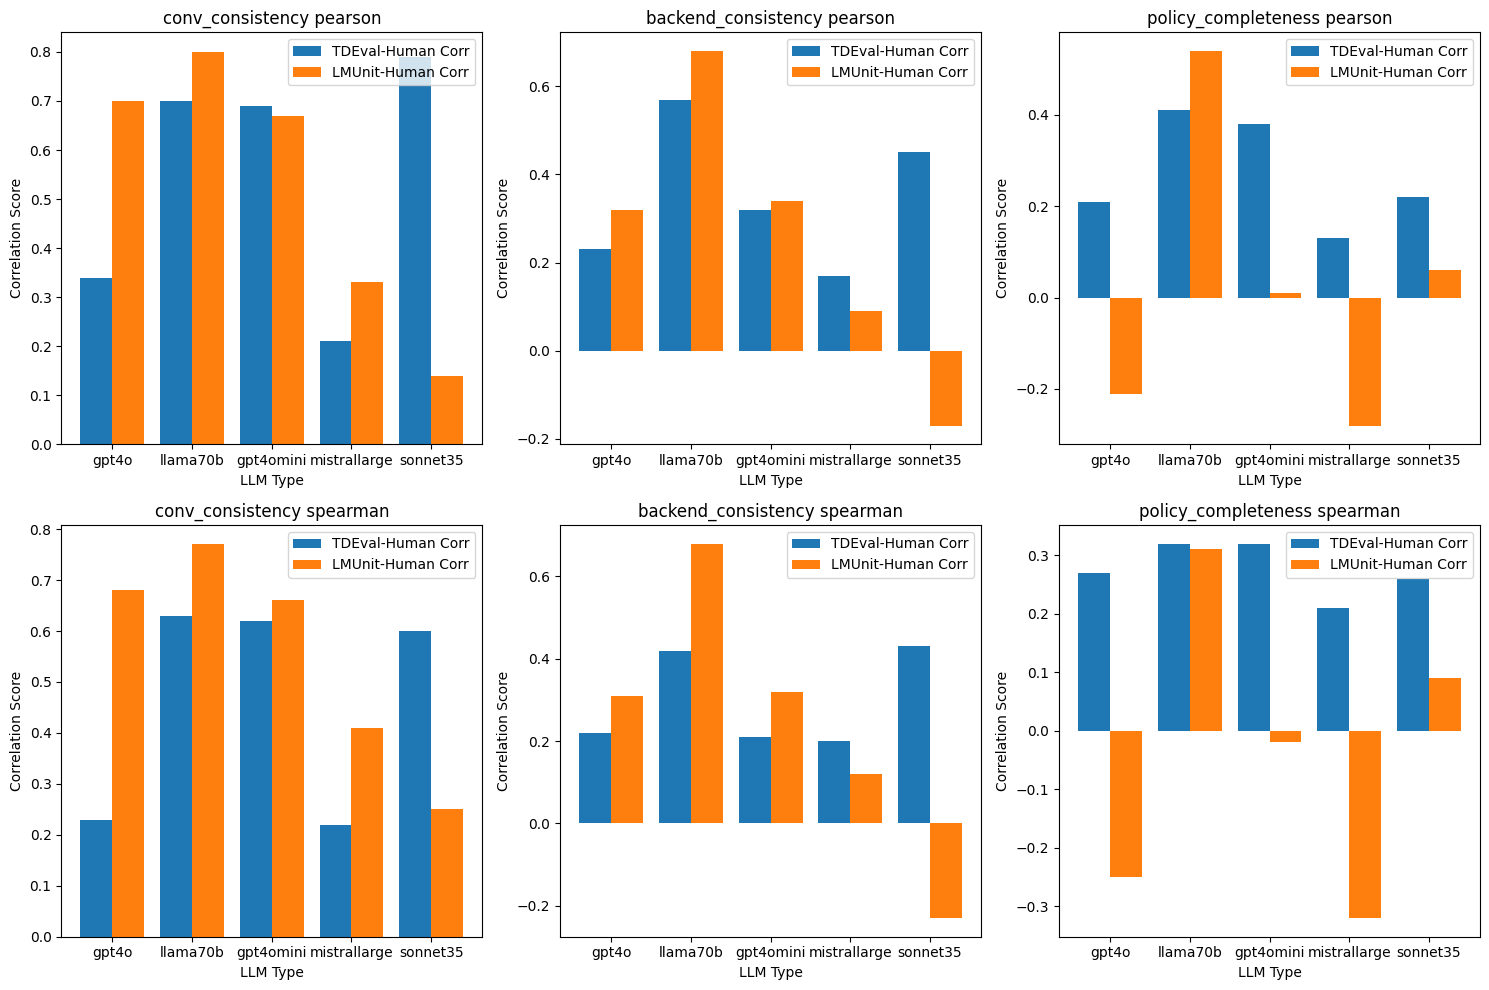

In [10]:
judge_comparisons[model]["correlations"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
tdeval = {}
lmunit = {}
for model, model_data in judge_comparisons.items():
    corrs = model_data["correlations"]
    tdeval_corrs = corrs["human_tdeval"]
    lmunit_corrs = corrs["human_lmunit"]
    for metric, corr_scores in lmunit_corrs.items():
        if metric not in tdeval:
            tdeval[metric] = {}
        if metric not in lmunit:
            lmunit[metric] = {}
        for corr_type, corr_type_score in corr_scores.items():
            if corr_type not in tdeval[metric]:
                tdeval[metric][corr_type] = []
            tdeval[metric][corr_type].append(tdeval_corrs[metric][corr_type]["score"])
            if corr_type not in lmunit[metric]:
                lmunit[metric][corr_type] = []
            lmunit[metric][corr_type].append(lmunit_corrs[metric][corr_type]["score"])

x_vals = list(judge_comparisons.keys())
x_axis = np.arange(len(models))
for i, metric in enumerate(tdeval.keys()):
    for j, corr_type in enumerate(tdeval[metric].keys()):
        ax = axs[j][i]
        ax.bar(x_axis-0.2, tdeval[metric][corr_type], 0.4, label='TDEval-Human Corr')
        ax.bar(x_axis+0.2, lmunit[metric][corr_type], 0.4, label='LMUnit-Human Corr')
        ax.set_xticks(x_axis, x_vals)
        ax.set_xlabel('LLM Type')
        ax.set_ylabel('Correlation Score')
        ax.set_title(f'{metric} {corr_type}')
        ax.legend()
fig.tight_layout()
plt.show()

#### Get Score Histogram

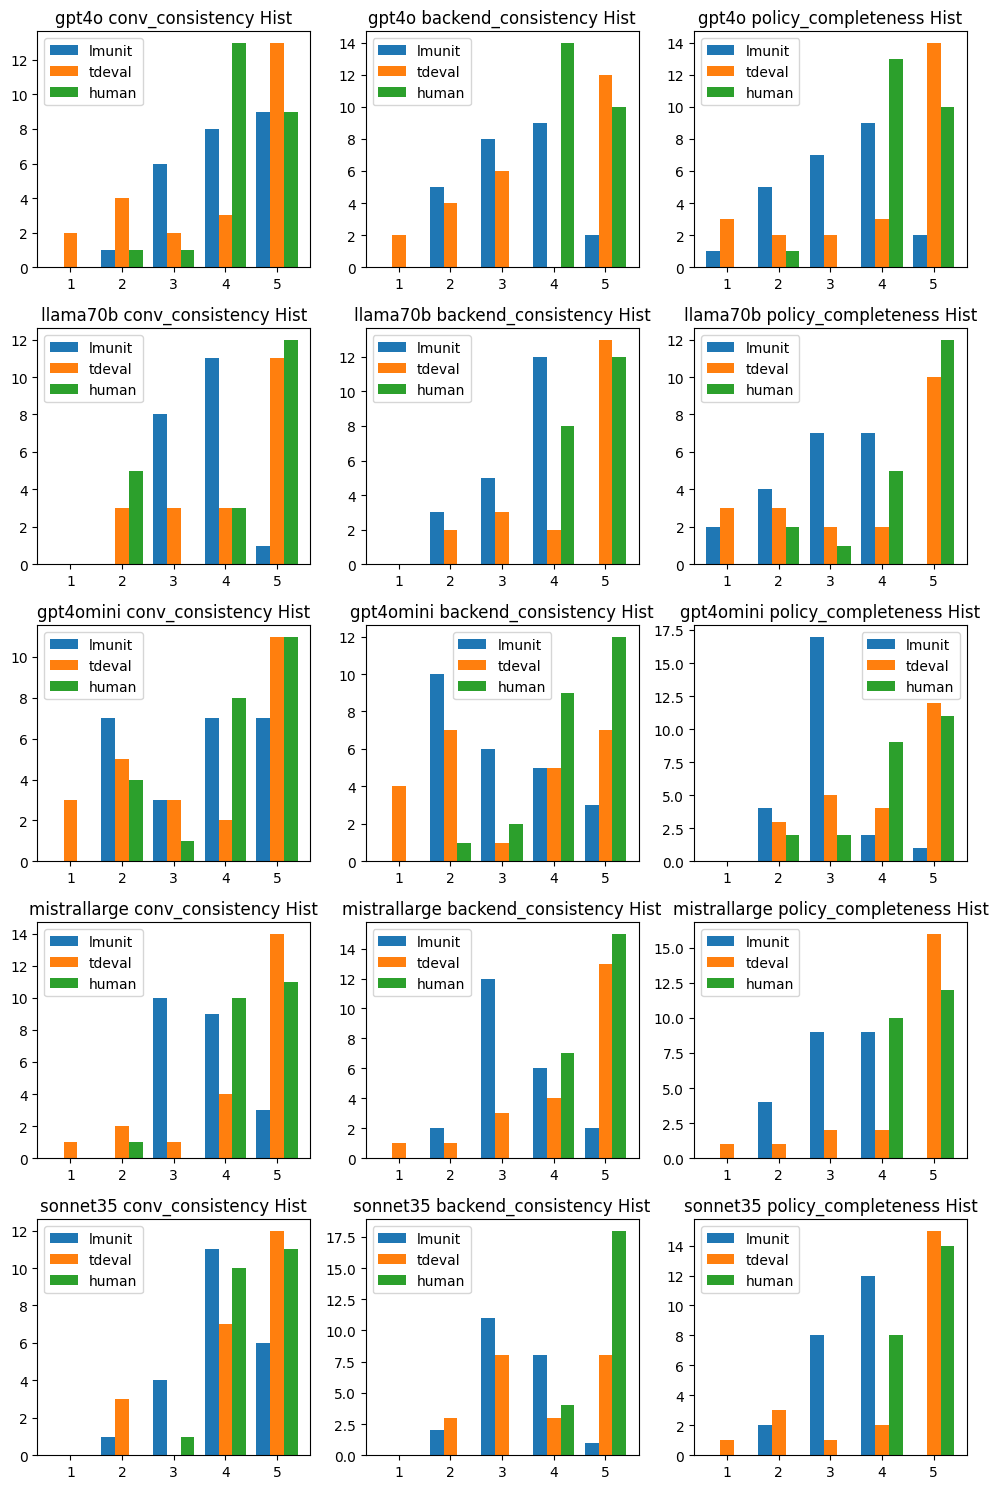

In [11]:
# Histogram comparing Human, TDEval, and LMUnit scores (5 subplots for 5 models)
bins = range(1, 7)
labels = ['lmunit', 'tdeval', 'human']
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10,15))
models_list = list(judge_comparisons.keys())
metrics_list = list(tdeval.keys())
norm_eval_scores = {}
for model in models_list:
    norm_eval_scores[model] = {}
    for metric in metrics_list:
        norm_eval_scores[model][metric] = {}
        for eval_type, evals in judge_comparisons[model].items():
            if eval_type == "correlations":
                continue
            norm_eval_scores[model][metric][eval_type] = []
            for dial_id, scores in evals.items():
                for s in scores:
                    norm_eval_scores[model][metric][eval_type].append(round(s[metric]))

for i, model in enumerate(models_list):
    for j, metric in enumerate(metrics_list):
        ax = axs[i][j]
        hists = np.array([
            norm_eval_scores[model][metric]["lmunit_scores"], 
            norm_eval_scores[model][metric]["tdeval_scores"], 
            norm_eval_scores[model][metric]["human_dial_scores"]
        ]).T
        # print(hists)
        ax.hist(hists, bins=bins, density=False, histtype='bar', label=labels, align='left')
        ax.legend()
        ax.set_title(f'{model} {metric} Hist')
fig.tight_layout()
plt.show()

